In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

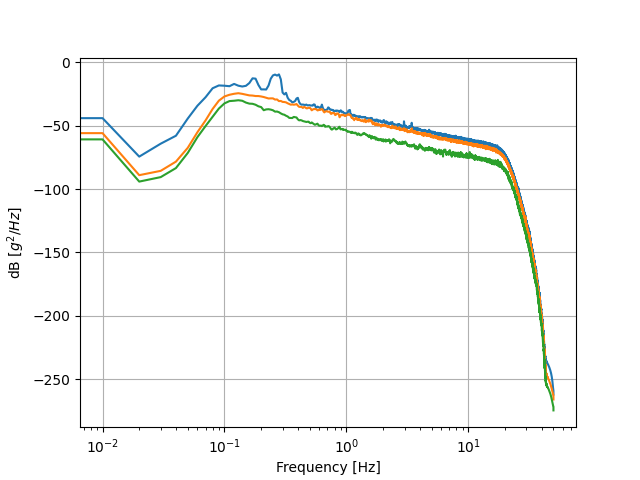

In [303]:
from utils import utils
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import PyOMA as oma

data, time = utils.load_decim_data_helper("../data/", "brake-test-bolt-config-2.h5")


data = data[1:4,:].transpose()
data.shape

# Import modules



# ======== PRE-PROCESSING =====================================================
# To open a .txt file create a variable containing the path to the file
# _file = "./test.txt" # Path to the txt file

# # open the file with pandas and create a dataframe
# # N.B. whatchout for header, separator and remove time column if present
# data = pd.read_csv(_file, header=0, sep="\t", index_col=False) 
# data = data.to_numpy()

# to retrieve the example data 
# data, (fex, FI_ex, xi_ex) = oma.Exdata()

# Sampling frequency
fs = 100 # [Hz] Sampling Frequency

# Using SciPy's signal module we can pre-process our data e.g. performing
# decimation, trend removal and filtering. 
# Detrend and decimate
data = signal.detrend(data, axis=0) # Trend rmoval
# q = 5 # Decimation factor
# data = signal.decimate(data,  q, ftype='fir', axis=0) # Decimation
# fs = fs/q # [Hz] Decimated sampling frequency

# Filter
_b, _a = signal.butter(5, (0.1,20), fs=fs, btype='bandpass')
filtdata = signal.filtfilt(_b, _a, data,axis=0) # filtered data

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
import mplcursors
import scipy

def FDDsvp(data, fs, df=0.01, pov=0.5, window='hann'):
    '''
    This function perform the Frequency Domain Decomposition algorithm.
    
    The function return the plot of the singular values of the power spectral
    density. The cross power spectral density is estimated using 
    scipy.signal.csd() function, which in turn is based on Welch's method.
    Furthermore it returns a dictionary that contains the results needed
    by the function FDDmodEX().
    ----------
    Parameters
    ----------
    data : array
        The time history records (Ndata x Nchannels).
    fs : float
        The sampling frequency.
    df : float
        Desired frequency resolution. Default to 0.01 (Hz).
    pov : float
        Percentage of overlap between segments. Default to 50%.
    window : str or tuple or array_like
        Desired window to use. Window is passed to scipy.signal's get_window
        function (see SciPy.org for more info). Default to "hann" which stands
        for a “Hanning” window.

    -------
    Returns
    -------
    fig1 : matplotlib figure
        Plot of the singular values of the power spectral matrix.
    Results : dictionary
        Dictionary of results to be passed to FDDmodEX()
    '''  
    
    # ndat=data.shape[0] # Number of data points
    nch=data.shape[1] # Number of channels
    freq_max = fs/2 # Nyquist frequency
    nxseg = fs/df # number of point per segments
#    nseg = ndat // nxseg # number of segments
    noverlap = nxseg // (1/pov) # Number of overlapping points
    
    # Initialization
    PSD_matr = np.zeros((nch, nch, int((nxseg)/2+1)), dtype=complex) 
    S_val = np.zeros((nch, nch, int((nxseg)/2+1))) 
    S_vec = np.zeros((nch, nch, int((nxseg)/2+1)), dtype=complex) 
    
    # Calculating Auto e Cross-Spectral Density
    for _i in range(0, nch):
        for _j in range(0, nch):
            _f, _Pxy = signal.csd(data[:, _i],data[:, _j], fs=fs, nperseg=nxseg, noverlap=noverlap, window=window)
            PSD_matr[_i, _j, :] = _Pxy
            
    # Singular value decomposition     
    for _i in range(np.shape(PSD_matr)[2]):
        U1, S1, _V1_t = np.linalg.svd(PSD_matr[:,:,_i])
        U1_1=np.transpose(U1) 
        S1 = np.diag(S1)
        S_val[:,:,_i] = S1
        S_vec[:,:,_i] = U1_1
    
    # Plot of the singular values in log scale
    fig, ax = plt.subplots()
    for _i in range(nch):
    #    ax.semilogy(_f, S_val[_i, _i]) # scala log
        ax.plot(_f[:], 10*np.log10(S_val[_i, _i])) # decibel
    ax.grid()
    # ax.set_xlim(left=0, right=freq_max)
    ax.xaxis.set_major_locator(MultipleLocator(freq_max/10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.xaxis.set_minor_locator(MultipleLocator(freq_max/100))
    # ax.set_title("Singular values plot - (Freq. res. ={0})".format(df))
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'dB $[g^2/Hz]$')    
    # ax.set_ylabel(r'dB $\left[\frac{\left(\frac{m}{s^2}\right)^2}{Hz}\right]$')    
    ax.set_xscale('log')
    mplcursors.cursor()
    
    Results={}
    Results['Data'] = {'Data': data}
    Results['Data']['Samp. Freq.'] = fs
    Results['Data']['Freq. Resol.'] = df
    Results['Singular Values'] = S_val
    Results['Singular Vectors'] = S_vec
    Results['PSD Matrix'] = PSD_matr
    
    return fig, Results

                
FDD = FDDsvp(filtdata,  fs)

In [286]:

# Define list/array with the peaks identified from the plot

FreQ = [0.27, 0.49] # identified peaks

# Extract the modal properties 
Res_FDD = oma.FDDmodEX(FreQ, FDD[1]) # extracting modal properties using standard FDD
# Res_EFDD = oma.EFDDmodEX(FreQ, FDD[1], method='EFDD') # " " " " Enhanced-FDD
# Res_FSDD = oma.EFDDmodEX(FreQ, FDD[1], method='FSDD', npmax = 35, MAClim=0.95, plot=True) # " " " " FSDD with additional input parameters
print('Frequencies: ', Res_FDD['Frequencies'])

Frequencies:  [0.28 0.5 ]


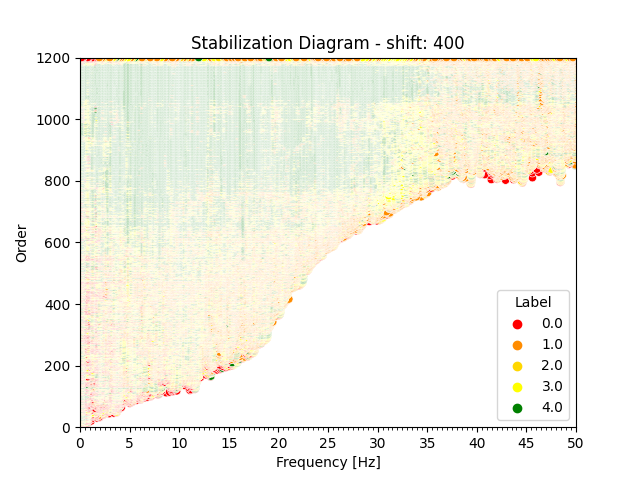

Frequencies:  [0.2730242  0.51222646]
Damping:  [0.02680208 0.04826744]


In [289]:


# Run SSI
br = 400
SSIcov= oma.SSIcovStaDiag(filtdata, fs, br) # running SSI-cov
# SSIdat = oma.SSIdatStaDiag(data, fs, br, ordmax=60, lim=(0.01, 0.05, 0.02, 0.1)) # running SSI-dat with additional input parameters

# Extract the modal properties
Res_SSIcov = oma.SSIModEX(FreQ, SSIcov[1]) # extracting modal properties
# Res_SSIdat= oma.SSIModEX(FreQ, SSIdat[1]) # extracting modal properties

print('Frequencies: ', Res_SSIcov['Frequencies'])
print('Damping: ', Res_SSIcov['Damping'])
# print('Mode Shapes: ', Res_SSIcov['Mode Shapes'])